In [ ]:
!pip uninstall -y tensorflow --quiet
!pip install ludwig
!pip install ludwig[llm]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 8.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.2/682.2 kB 61.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.8/80.8 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 kB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 15.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.6/85.6 kB 13.4 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=0bc9f8f67fd7d48ead60e70e88f560eafc50155b54c02739239b9c230e173b58
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))

get_ipython().events.register('pre_run_cell', set_css)

def clear_cache():
  if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [ ]:
import getpass
import locale; locale.getpreferredencoding = lambda: "UTF-8"
import logging
import os
import torch
import yaml

from ludwig.api import LudwigModel


os.environ["HUGGING_FACE_HUB_TOKEN"] = getpass.getpass("Token:")
assert os.environ["HUGGING_FACE_HUB_TOKEN"]

Token:··········


In [ ]:
from google.colab import data_table; data_table.enable_dataframe_formatter()
import numpy as np; np.random.seed(123)
import pandas as pd

df = pd.read_json("/content/drive/MyDrive/dataset_train.json")

# 90% will be assigned a value of 0 -> train set
# 5% will be assigned a value of 1 -> validation set
# 5% will be assigned a value of 2 -> test set
total_rows = len(df)
split_0_count = int(total_rows * 0.9)
split_1_count = int(total_rows * 0.05)
split_2_count = total_rows - split_0_count - split_1_count

# Create an array with split values based on the counts
split_values = np.concatenate([
    np.zeros(split_0_count),
    np.ones(split_1_count),
    np.full(split_2_count, 2)
])

np.random.shuffle(split_values)

df['split'] = split_values
df['split'] = df['split'].astype(int)


In [ ]:
# df = df.sample(frac = 1)
# df = df.head(n=1000)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6849 entries, 0 to 6848
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   instruction  6849 non-null   object
 1   input        6849 non-null   object
 2   output       6849 non-null   object
 3   split        6849 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 214.2+ KB


In [ ]:
num_self_sufficient = (df['input'] == '').sum()
num_need_context = df.shape[0] - num_self_sufficient

print(f"Total number of examples in the dataset: {df.shape[0]}")

print(f"% of examples that are self-sufficient: {round(num_self_sufficient/df.shape[0] * 100, 2)}")
print(f"% of examples that are need additional context: {round(num_need_context/df.shape[0] * 100, 2)}")

Total number of examples in the dataset: 6849
% of examples that are self-sufficient: 0.0
% of examples that are need additional context: 100.0


Average number of tokens in the instruction column: 145
Average number of tokens in the input column: 25
Average number of tokens in the output column: 8



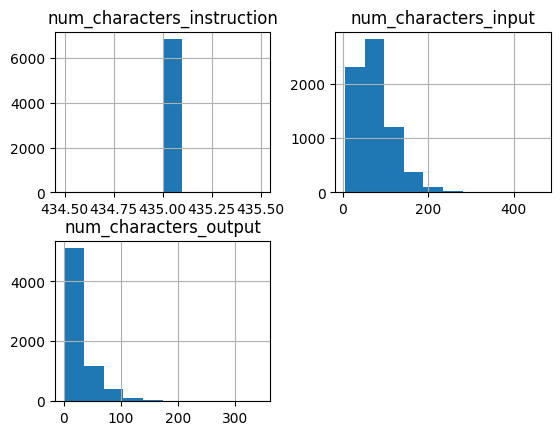

In [ ]:
df['num_characters_instruction'] = df['instruction'].apply(lambda x: len(x))
df['num_characters_input'] = df['input'].apply(lambda x: len(x))
df['num_characters_output'] = df['output'].apply(lambda x: len(x))

df.hist(column=['num_characters_instruction', 'num_characters_input', 'num_characters_output'])

average_chars_instruction = df['num_characters_instruction'].mean()
average_chars_input = df['num_characters_input'].mean()
average_chars_output = df['num_characters_output'].mean()

print(f'Average number of tokens in the instruction column: {(average_chars_instruction / 3):.0f}')
print(f'Average number of tokens in the input column: {(average_chars_input / 3):.0f}')
print(f'Average number of tokens in the output column: {(average_chars_output / 3):.0f}', end="\n\n")

In [ ]:
from transformers import AutoTokenizer
import numpy as np

def calculate_distribution(data_dict):
    result = {}

    for key, values in data_dict.items():
        values = np.array(values)
        result[key] = {
            'average': int(np.mean(values)),
            'min': np.min(values),
            'max': np.max(values),
            'median': np.median(values),
            '75th_percentile': int(np.percentile(values, 75)),
            '90th_percentile': int(np.percentile(values, 90)),
            '95th_percentile': int(np.percentile(values, 95)),
            '99th_percentile': int(np.percentile(values, 99))
        }

    return result

tokenizer = AutoTokenizer.from_pretrained('meta-llama/Llama-2-7b-hf')

token_counts = {
    "instruction": [],
    "input": [],
    "output": [],
    "total": []
}

for index, row in df.iterrows():
    instruction_col_tokens = len(tokenizer.tokenize(row['instruction']))
    input_col_tokens = len(tokenizer.tokenize(row['input']))
    output_col_tokens = len(tokenizer.tokenize(row['output']))
    total = instruction_col_tokens + input_col_tokens + output_col_tokens

    token_counts['instruction'].append(instruction_col_tokens)
    token_counts['input'].append(input_col_tokens)
    token_counts['output'].append(output_col_tokens)
    token_counts['total'].append(total)

token_distribution = calculate_distribution(token_counts)
token_distribution = pd.DataFrame(token_distribution)
token_distribution

,instruction,input,output,total
average,94.0,18.0,9.0,121.0
min,94.0,2.0,1.0,97.0
max,94.0,103.0,134.0,295.0
median,94.0,17.0,7.0,117.0
75th_percentile,94.0,24.0,12.0,130.0
90th_percentile,94.0,33.0,24.0,146.0
95th_percentile,94.0,39.0,30.0,158.0
99th_percentile,94.0,56.0,48.0,188.0


import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_0, *['input'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_1, *['output'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_2, *['total'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(_df_3, *['index'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plot(df, x_colname, y_colname, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(6 * figscale, 6 * figscale))
  df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha)
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plot(_df_4, *['input', 'output'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plot(df, x_colname, y_colname, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(6 * figscale, 6 * figscale))
  df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha)
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plot(_df_5, *['output', 'total'], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(_df_6, *['instruction', 'input', 'index'], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(_df_7, *['instruction', 'output', 'index'], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(_df_8, *['instruction', 'total', 'index'], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(_df_9, *['instruction', 'count()', 'index'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_10, *['input'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_11, *['output'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_12, *['total'], **{})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(_df_13, *['input', 'index'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(_df_14, *['output', 'index'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(_df_15, *['total', 'index'], **{'inner': 'stick'})
chart

In [ ]:
model = None
clear_cache()

qlora_fine_tuning_config = yaml.safe_load(
"""
model_type: llm
base_model: meta-llama/Llama-2-7b-hf

input_features:
  - name: instruction
    type: text

output_features:
  - name: output
    type: text

prompt:
  template: >-
    Below is an instruction that describes a task, paired with an input
    that provides further context. Write a response that appropriately
    completes the request.

    ### Instruction: {instruction}

    ### Input: {input}

    ### Response:

generation:
  temperature: 0.2
  max_new_tokens: 2048

adapter:
  type: lora

quantization:
  bits: 4

preprocessing:
  global_max_sequence_length: 512
  split:
    type: random
    probabilities:
    - 0.7
    - 0.1
    - 0.2

trainer:
  type: finetune
  epochs: 1
  batch_size: 1
  eval_batch_size: 2
  gradient_accumulation_steps: 16
  learning_rate: 0.0004
  learning_rate_scheduler:
    warmup_fraction: 0.03
"""
)

model = LudwigModel(config=qlora_fine_tuning_config, logging_level=logging.INFO)
results = model.train(dataset=df)

INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒════════════════════════╕
INFO:ludwig.utils.print_utils:│ EXPERIMENT DESCRIPTION │
INFO:ludwig.utils.print_utils:╘════════════════════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.api:╒══════════════════╤═════════════════════════════════════════════════════════════════════════════════════════╕
│ Experiment name  │ api_experiment                                                                          │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Model name       │ run                                                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Output directory │ /content/results/api_experiment_run                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────

INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of meta-llama/Llama-2-7b-hf tokenizer


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
INFO:ludwig.features.text_feature:Max length of feature 'None': 235 (without start and stop symbols)
INFO:ludwig.features.text_feature:Setting max length using dataset: 237 (including start and stop symbols)
INFO:ludwig.features.text_feature:max sequence length is 237 for feature 'None'
INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of meta-llama/Llama-2-7b-hf tokenizer
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
INFO:ludwig.features.text_feature:Max length of feature 'output': 134 (without start and stop symbols)
INFO:ludwig.features.text_feature:Setting max length using dataset: 136 (including start and stop symbols)
INFO:ludwig.features.text_feature:max sequence length is 136 for feature 'output'
INFO:ludwig.utils.tokenizers:Loaded H

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:ludwig.models.llm:Done.
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of meta-llama/Llama-2-7b-hf tokenizer
INFO:ludwig.models.llm:==================================================
INFO:ludwig.models.llm:Trainable Parameter Summary For Fine-Tuning
INFO:ludwig.models.llm:Fine-tuning with adapter: lora
INFO:ludwig.models.llm:==================================================
INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒══════════╕
INFO:ludwig.utils.print_utils:│ TRAINING │
INFO:ludwig.util

trainable params: 4,194,304 || all params: 6,742,609,920 || trainable%: 0.06220594176090199


INFO:ludwig.trainers.trainer:Creating fresh model training run.
INFO:ludwig.trainers.trainer:Training for 4795 step(s), approximately 1 epoch(s).
INFO:ludwig.trainers.trainer:Early stopping policy: 5 round(s) of evaluation, or 23975 step(s), approximately 5 epoch(s).

INFO:ludwig.trainers.trainer:Starting with step 0, epoch: 0


Training: 100%|█████████▉| 4794/4795 [57:10<00:00,  1.39it/s, loss=0.0307]

INFO:ludwig.data.batcher.random_access:Last batch in epoch only has 1 sample and will be dropped.


Training: 100%|██████████| 4795/4795 [57:11<00:00,  1.31it/s, loss=0.00383]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 4795, epoch: 1


Evaluation test : 100%|██████████| 685/685 [06:37<00:00,  1.72it/s]

INFO:ludwig.trainers.trainer:Evaluation took 9m 54.5565s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤════════════╤══════════════╤════════════╕
│                       │      train │   validation │       test │
╞═══════════════════════╪════════════╪══════════════╪════════════╡
│ bleu                  │     0.0000 │       0.0101 │     0.0109 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ char_error_rate       │    21.1739 │      17.8684 │    16.1250 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ loss                  │     0.0612 │       0.2463 │     0.2566 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ next_token_perplexity │ 12425.9902 │   13080.8564 │ 13101.9229 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ perplexity            │ 32001.6504 │   31995.9141 │ 31993.7480 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ rouge1_fmeasure       │     0


Training: 100%|██████████| 4795/4795 [1:07:06<00:00,  1.19it/s, loss=0.00383]

INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒═════════════════╕
INFO:ludwig.utils.print_utils:│ TRAINING REPORT │
INFO:ludwig.utils.print_utils:╘═════════════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.api:╒══════════════════════════════╤═════════════════════╕
│ Validation feature           │ output              │
├──────────────────────────────┼─────────────────────┤
│ Validation metric            │ loss                │
├──────────────────────────────┼─────────────────────┤
│ Best model step              │ 4795                │
├──────────────────────────────┼─────────────────────┤
│ Best model epoch             │ 2                   │
├──────────────────────────────┼─────────────────────┤
│ Best model's validation loss │ 0.24634888768196106 │
├──────────────────────────────┼─────────────────────┤
│ Best model's test loss       │ 0.25662243366241455 │
╘══════════════════════════════╧═════════════════════╛
INFO:ludwig.api:
Finished: api_experiment_run
INFO:ludwig

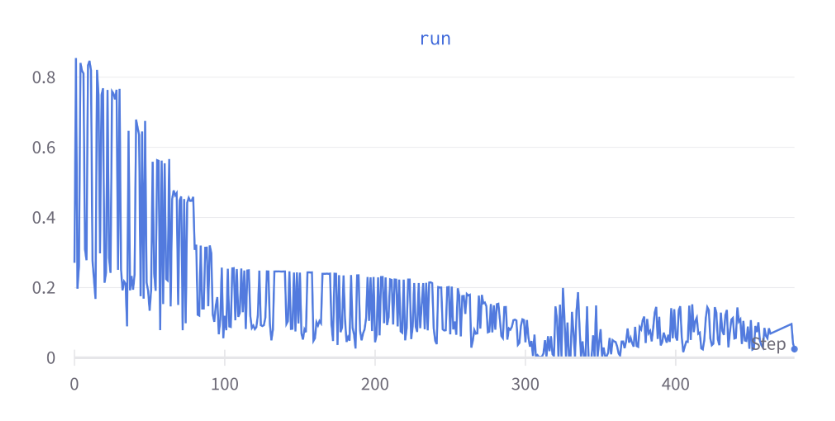

In [ ]:
!ludwig upload ollama --repo_id aish/svce-ai --model_path /content/results/api_experiment_run

In [ ]:
results[0]

TrainingStats(training={'output': {'bleu': [0.0], 'char_error_rate': [21.173913955688477], 'loss': [0.0612303800880909], 'next_token_perplexity': [12425.990234375], 'perplexity': [32001.650390625], 'rouge1_fmeasure': [0.051948051899671555], 'rouge1_precision': [0.02666666731238365], 'rouge1_recall': [1.0], 'rouge2_fmeasure': [0.02666666731238365], 'rouge2_precision': [0.013513513840734959], 'rouge2_recall': [1.0], 'rougeL_fmeasure': [0.051948051899671555], 'rougeL_precision': [0.02666666731238365], 'rougeL_recall': [1.0], 'rougeLsum_fmeasure': [0.051948051899671555], 'rougeLsum_precision': [0.02666666731238365], 'rougeLsum_recall': [1.0], 'sequence_accuracy': [0.0], 'token_accuracy': [0.0], 'word_error_rate': [41.5]}, 'combined': {'loss': [0.0612303800880909]}}, validation={'output': {'bleu': [0.010059062391519547], 'char_error_rate': [17.868410110473633], 'loss': [0.24634888768196106], 'next_token_perplexity': [13080.8564453125], 'perplexity': [31995.9140625], 'rouge1_fmeasure': [0.05

In [ ]:
!pip install ptitprince

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.1/283.1 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.9/52.9 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2


In [ ]:
from ludwig import visualize
visualize.learning_curves(
  results[0],
  output_feature_name=None,
  model_names=None,
  output_directory=None,
  file_format='png',
  callbacks=None
)


In [ ]:
test_stats_per_model

({'output': {'loss': 10.373497009277344,
   'token_accuracy': 0.005760104861110449,
   'sequence_accuracy': 0.0,
   'perplexity': 32000.185546875,
   'next_token_perplexity': 32000.0859375,
   'bleu': 0.33909106254577637,
   'rouge1_fmeasure': 0.48997294902801514,
   'rouge1_precision': 0.5026670694351196,
   'rouge1_recall': 0.49732354283332825,
   'rouge2_fmeasure': 0.4718836843967438,
   'rouge2_precision': 0.4918919503688812,
   'rouge2_recall': 0.48154759407043457,
   'rougeL_fmeasure': 0.4885443449020386,
   'rougeL_precision': 0.5010004043579102,
   'rougeL_recall': 0.49607354402542114,
   'rougeLsum_fmeasure': 0.4885443449020386,
   'rougeLsum_precision': 0.5010004043579102,
   'rougeLsum_recall': 0.49607354402542114,
   'word_error_rate': 0.4776119291782379,
   'char_error_rate': 0.5875358581542969},
  'combined': {'loss': 10.373497009277344}},
 Empty DataFrame
 Columns: []
 Index: [],
 'results')

In [ ]:
results[0]

TrainingStats(training={'output': {'bleu': [0.0], 'char_error_rate': [21.173913955688477], 'loss': [0.0612303800880909], 'next_token_perplexity': [12425.990234375], 'perplexity': [32001.650390625], 'rouge1_fmeasure': [0.051948051899671555], 'rouge1_precision': [0.02666666731238365], 'rouge1_recall': [1.0], 'rouge2_fmeasure': [0.02666666731238365], 'rouge2_precision': [0.013513513840734959], 'rouge2_recall': [1.0], 'rougeL_fmeasure': [0.051948051899671555], 'rougeL_precision': [0.02666666731238365], 'rougeL_recall': [1.0], 'rougeLsum_fmeasure': [0.051948051899671555], 'rougeLsum_precision': [0.02666666731238365], 'rougeLsum_recall': [1.0], 'sequence_accuracy': [0.0], 'token_accuracy': [0.0], 'word_error_rate': [41.5]}, 'combined': {'loss': [0.0612303800880909]}}, validation={'output': {'bleu': [0.010059062391519547], 'char_error_rate': [17.868410110473633], 'loss': [0.24634888768196106], 'next_token_perplexity': [13080.8564453125], 'perplexity': [31995.9140625], 'rouge1_fmeasure': [0.05

In [ ]:
type(results[1])

ludwig.api.PreprocessedDataset

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

In [ ]:
!ludwig visualize --visualization confidence_thresholding \
  --ground_truth_metadata /content/h.json \
  --test_statistics /content/results/api_experiment_run/training_statistics.json \
  --top_n_classes 2 \
  --model_names A \
  --output_feature_name output \
  --ground_truth /content/trial_lap.json

Created a temporary directory at /tmp/tmp3ptz3inx
Writing /tmp/tmp3ptz3inx/_remote_module_non_scriptable.py
Unable to vectorize using str2idx with exception '["appetizers", "positive"] \n["salads", "positive"] \n["steak", "positive"] \n["pasta", "positive"]'. Falling back to ignoring str2idx
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Figure(640x480)


In [ ]:
!zip -r /content/file.zip /content/results

  adding: content/results/ (stored 0%)
  adding: content/results/api_experiment_run/ (stored 0%)
  adding: content/results/api_experiment_run/model/ (stored 0%)
  adding: content/results/api_experiment_run/model/model_weights/ (stored 0%)
  adding: content/results/api_experiment_run/model/model_weights/README.md (deflated 67%)
  adding: content/results/api_experiment_run/model/model_weights/adapter_model.bin (deflated 8%)
  adding: content/results/api_experiment_run/model/model_weights/adapter_config.json (deflated 43%)
  adding: content/results/api_experiment_run/model/model_hyperparameters.json (deflated 88%)
  adding: content/results/api_experiment_run/model/training_set_metadata.json (deflated 83%)
  adding: content/results/api_experiment_run/model/training_checkpoints/ (stored 0%)
  adding: content/results/api_experiment_run/model/training_checkpoints/best.ckpt (deflated 8%)
  adding: content/results/api_experiment_run/model/training_checkpoints/latest.ckpt (deflated 8%)
  adding: